# Resolutions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import matplotlib
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import millefeuille as mf
import pickle
from scipy import stats
from retro.utils.stats import estimate
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import pandas

In [138]:
rootdir = '/data/justin/retro/recos/2018-03-28/tblptlog/'

p = re.compile(r'evt.\d-llhp.npy')

events = []

# this is just because of a mismatch
new_names = ('llh', 'z', 'track_azimuth', 'track_zenith', 'track_energy', 'y', 'cascade_energy', 't', 'x')

prev_subdir = None

mn_failed = 0
estimator_failed = 0

for subdir, dirs, files in os.walk(rootdir):
    print subdir
    # load truth
    
    if len(files) == 0:
        continue
    
    if not subdir == prev_subdir:
        with open(os.path.join('/data/icecube/sim/ic86/retro/1460/', os.path.basename(subdir), 'mc_truth.pkl'), 'rb') as f:
            truth_file = pickle.load(f)
        with open(os.path.join('/data/icecube/sim/ic86/retro/1460/', os.path.basename(subdir), 'recos/IC86_Dunkman_L6_MultiNest8D_Track.pkl'), 'rb') as f:
            track_file = pickle.load(f)
        with open(os.path.join('/data/icecube/sim/ic86/retro/1460/', os.path.basename(subdir), 'recos/IC86_Dunkman_L6_MultiNest8D_Cascade.pkl'), 'rb') as f:
            cascade_file = pickle.load(f)
        with open(os.path.join('/data/icecube/sim/ic86/retro/1460/', os.path.basename(subdir), 'recos/SPEFit2.pkl'), 'rb') as f:
            spefit_file = pickle.load(f)
        prev_subdir == subdir
    
    for file in files:
        if p.match(file):
            event_number = int(re.sub('[^0-9]', '', file))

            llhp_data = np.load(os.path.join(subdir, file))
            if len(llhp_data['llh']) < 5000:
                print 'event %i bad (N=%i)'%(event_number, len(llhp_data['llh']))
                mn_failed += 1
                continue
                    
            #llhp_data.dtype.names = new_names
            try:
                estimator = estimate(llhp_data, percentile_nd=0.99)
            except IndexError:
                print 'event %i estimator failed'%(event_number)
                estimator_failed += 1
                continue
                
            event = {}
            
            # --- Retro ---
            # construct "energy"
            estimator['mean']['energy'] = estimator['mean']['cascade_energy'] + estimator['mean']['track_energy']
            estimator['weighted_mean']['energy'] = estimator['weighted_mean']['cascade_energy'] + estimator['weighted_mean']['track_energy']
            estimator['median']['energy'] = estimator['median']['cascade_energy'] + estimator['median']['track_energy']
            estimator['weighted_median']['energy'] = estimator['weighted_median']['cascade_energy'] + estimator['weighted_median']['track_energy']
            estimator['low']['energy'] = estimator['low']['cascade_energy'] + estimator['low']['track_energy']
            estimator['high']['energy'] = estimator['high']['cascade_energy'] + estimator['high']['track_energy']
            # add to dict
            for key in estimator['mean'].keys():
                event['retro_%s_mean'%key] = estimator['mean'][key]
                event['retro_%s_weighted_mean'%key] = estimator['weighted_mean'][key]
                event['retro_%s_median'%key] = estimator['median'][key]
                event['retro_%s_weighted_median'%key] = estimator['weighted_median'][key]
                event['retro_%s'%key] = estimator['weighted_median'][key]
                event['retro_%s_high'%key] = estimator['high'][key]
                event['retro_%s_low'%key] = estimator['low'][key]
                event['retro_%s_delta'%key] = estimator['high'][key] - estimator['low'][key]
                
            # --- Truth ---                
            truth = truth_file[event_number]
            truth['track_azimuth'] = truth['azimuth']
            truth['track_zenith'] = np.arccos(truth['coszen'])
            truth['track_energy'] = truth['highest_energy_daughter_energy']
            truth['neutrino_energy'] = truth['energy']
            truth['energy'] = truth['track_energy'] + truth['cascade_energy'] 
            truth['t'] = truth['time']
            event.update(truth)

            # --- Pegleg ---
            event['pegleg_x'] = track_file[event_number]['x']
            event['pegleg_y'] = track_file[event_number]['y']
            event['pegleg_z'] = track_file[event_number]['z']
            event['pegleg_t'] = track_file[event_number]['time']
            event['pegleg_track_azimuth'] = track_file[event_number]['azimuth']
            event['pegleg_track_zenith'] = track_file[event_number]['zenith']
            event['pegleg_track_energy'] = track_file[event_number]['energy']
            event['pegleg_cascade_energy'] = cascade_file[event_number]['energy']
            event['pegleg_energy'] = event['pegleg_track_energy'] + event['pegleg_cascade_energy']

            # --- SPEFit ---
            spefit = spefit_file[event_number]
            event['spefit_x'] = spefit['x']
            event['spefit_y'] = spefit['y']
            event['spefit_z'] = spefit['z']
            event['spefit_t'] = spefit['time']
            event['spefit_track_zenith'] = spefit['zenith']
            event['spefit_track_azimuth'] = spefit['azimuth']

            
            events.append(event)

/data/justin/retro/recos/2018-03-28/tblptlog/
/data/justin/retro/recos/2018-03-28/tblptlog/25
event 21 bad (N=1370)
event 58 bad (N=1117)
event 60 bad (N=1280)
event 94 bad (N=938)
/data/justin/retro/recos/2018-03-28/tblptlog/21
event 80 bad (N=701)
event 30 bad (N=848)
event 95 bad (N=947)
event 74 bad (N=3158)
event 90 estimator failed
event 55 bad (N=984)
/data/justin/retro/recos/2018-03-28/tblptlog/12
event 32 bad (N=917)
event 80 bad (N=950)
event 51 bad (N=739)
event 97 bad (N=892)
/data/justin/retro/recos/2018-03-28/tblptlog/27
event 48 bad (N=791)
event 65 bad (N=957)
/data/justin/retro/recos/2018-03-28/tblptlog/8
event 97 bad (N=1120)
event 78 bad (N=1002)
/data/justin/retro/recos/2018-03-28/tblptlog/3
/data/justin/retro/recos/2018-03-28/tblptlog/20
event 13 bad (N=1507)
/data/justin/retro/recos/2018-03-28/tblptlog/18
event 28 bad (N=652)
event 75 bad (N=1063)
event 79 bad (N=887)
/data/justin/retro/recos/2018-03-28/tblptlog/7
event 29 bad (N=874)
/data/justin/retro/recos/2018

In [139]:
data = mf.DataStack('data')
data.add_layer(mf.PointLayer(pandas.DataFrame(events), 'events'))

In [140]:
print 'good :',len(data['events'].data)
print 'failed :',mn_failed
print 'estimator failed :', estimator_failed

good : 1690
failed : 77
estimator failed : 3


In [173]:
e_bins = mf.Grid(var='energy', edges=np.logspace(0.5,2.5,9))

In [178]:
data.add_layer(mf.BinLayer(e_bins, 'e_bins'))

AttributeError: 'Grid' object has no attribute 'vars'

In [166]:
mask = np.logical_and(np.logical_and(np.logical_and(data['events']['retro_track_zenith_delta'] < 10, data['events']['retro_x_delta'] < 50),data['events']['retro_y_delta'] < 50), data['events']['retro_z_delta'] < 30)

In [167]:
energy_corr_cscd = 1.0
energy_corr_trck = 1.0
energy_offset = 0.
data['events']['retro_neutrino_energy'] = energy_corr_trck*data['events']['retro_track_energy'] + energy_corr_cscd*data['events']['retro_cascade_energy'] + energy_offset
data['events']['retro_neutrino_energy_low'] = energy_corr_trck*data['events']['retro_track_energy_low'] + energy_corr_cscd*data['events']['retro_cascade_energy_low'] + energy_offset
data['events']['retro_neutrino_energy_high'] = energy_corr_trck*data['events']['retro_track_energy_high'] + energy_corr_cscd*data['events']['retro_cascade_energy_high'] + energy_offset
data['events']['pegleg_neutrino_energy'] = data['events']['pegleg_energy']

In [168]:
data['events']['retro_x_weighted_median']

array([ -41.72761223,   63.64085135,  130.77663435, ...,  124.6353982 ,
         58.08852473,   74.88843358])


--- retro ---
x width = 12.747, bias = 0.357
y width = 14.415, bias = 0.011
z width = 6.620, bias = 1.106
t width = 44.123, bias = 20.201
track_zenith width = 0.334, bias = -0.042
track_azimuth width = 0.905, bias = 0.020
track_energy width = 5.995, bias = -0.097
cascade_energy width = 4.793, bias = 2.439
energy width = 8.255, bias = 2.524

--- pegleg ---
x width = 13.679, bias = 0.054
y width = 15.920, bias = -0.253
z width = 7.629, bias = 2.009
t width = 45.496, bias = 38.105
track_zenith width = 0.373, bias = -0.010
track_azimuth width = 1.003, bias = 0.003
track_energy width = 6.773, bias = -1.176
cascade_energy width = 9.768, bias = 6.981
energy width = 12.128, bias = 6.511

--- spefit ---
x width = 28.282, bias = 1.077
y width = 29.589, bias = 0.925
z width = 23.777, bias = 6.491
t width = 132.208, bias = 99.272
track_zenith width = 0.595, bias = 0.151
track_azimuth width = 1.409, bias = 0.023
track_energy width = 9.841, bias = -8.702
cascade_energy width = 5.377, bias = -2.462


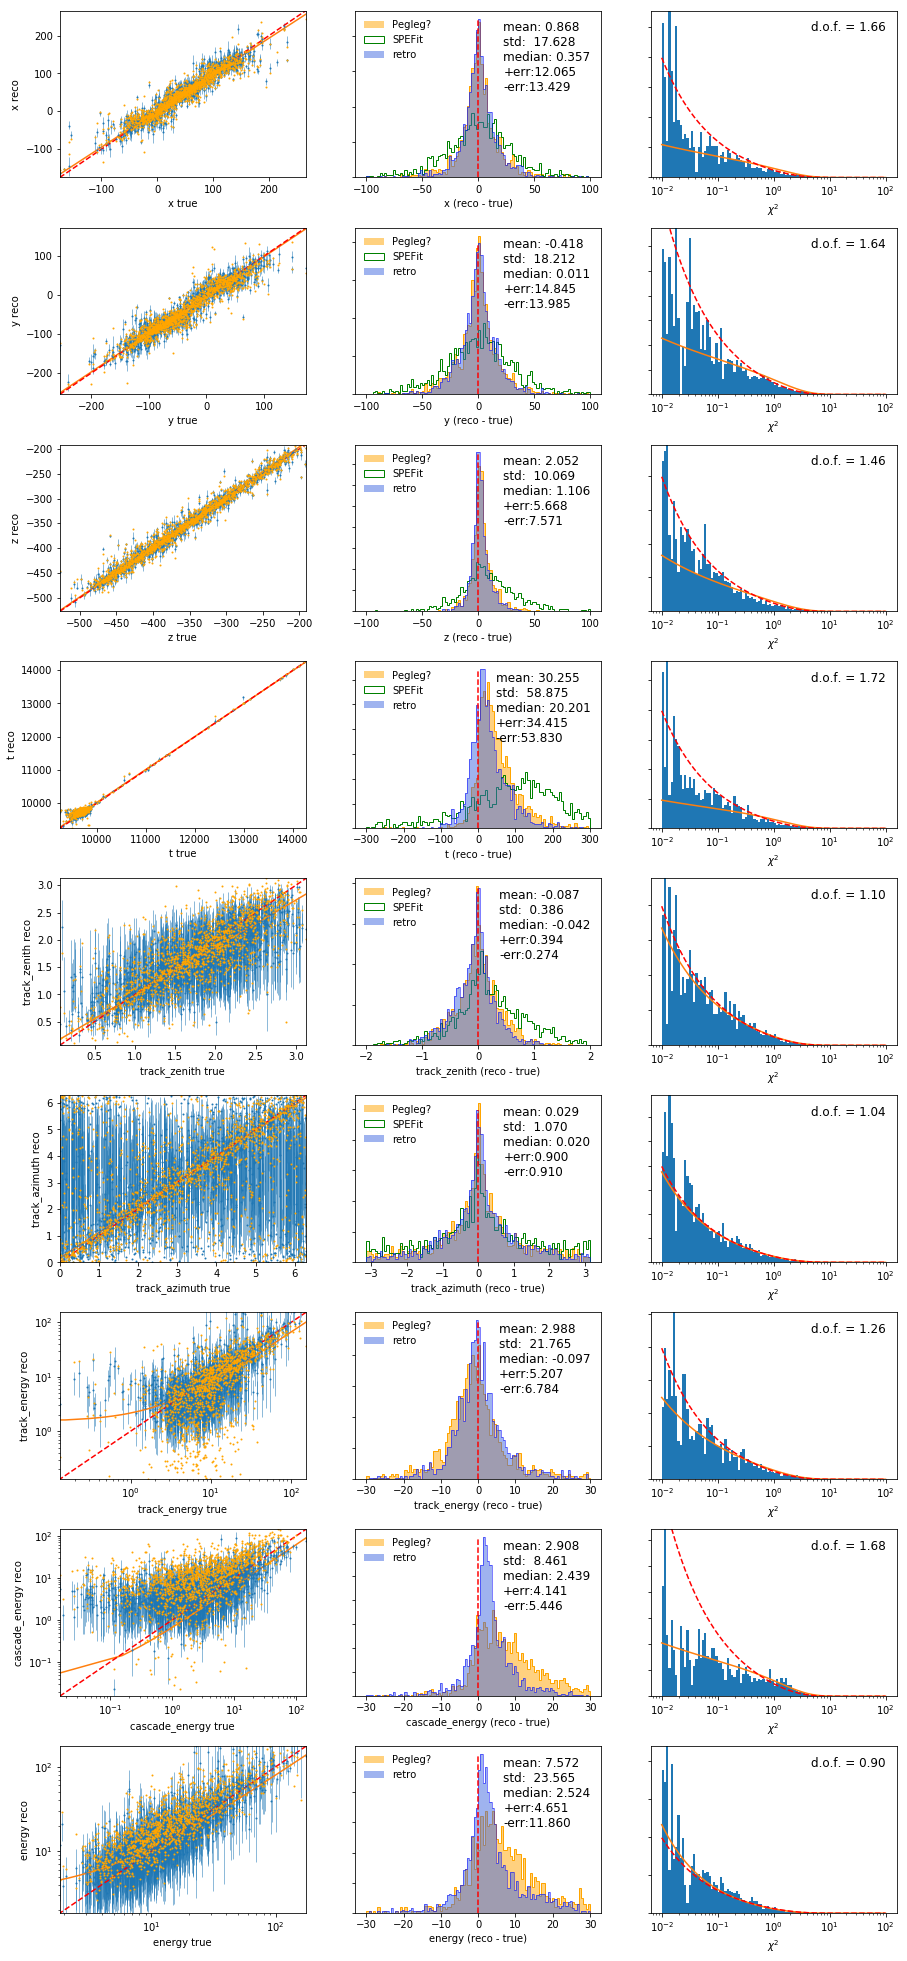

In [170]:
fig, axes = plt.subplots(figsize=(15, 35), ncols=3, nrows=9)
plt.subplots_adjust(hspace = 0.3)

res = []
pegres = []
speres = []

for i, dim in enumerate(['x', 'y', 'z', 't', 'track_zenith', 'track_azimuth', 'track_energy', 'cascade_energy', 'energy']):#, 'neutrino_energy']):
#for i, dim in enumerate(['neutrino_energy']):
    
    ax1 = axes[i,0]
    ax2 = axes[i,1]
    ax3 = axes[i,2]

    estimator = '_weighted_mean'
    
    x_true = np.nan_to_num(data['events'][dim][mask])

    key = dim
    x_reco = np.nan_to_num(data['events']['retro_'+key+estimator][mask])
    x_high = data['events']['retro_'+key+'_high'][mask]
    x_low = data['events']['retro_'+key+'_low'][mask]
    pegleg = data['events']['pegleg_'+key][mask]
    try:
        spefit = np.nan_to_num(data['events']['spefit_'+key][mask])
    except KeyError:
        spefit = np.zeros_like(x_true)
        
    sigma_m = x_reco - x_low
    sigma_p = x_high - x_reco

    # reco vs. ture

    ax1.errorbar(x_true, x_reco, yerr= (sigma_m, sigma_p), marker='.', ls='',lw=0.5, markersize=2)
    ax1.errorbar(x_true, pegleg, marker='.', c='orange', markersize=2, ls='')

    
    ax1.set_xlabel('%s true'%dim)
    ax1.set_ylabel('%s reco'%dim)
    
    if 'energy' in dim:
        ax1.set_xscale('log')
        ax1.set_yscale('log')

    ax1.set_ylim(x_true[x_true != 0].min(), x_true.max())
    ax1.set_xlim(x_true[x_true != 0].min(), x_true.max())        
    fit = np.polyfit(x_true, x_reco, 1, w = 1./(x_high - x_low))
    x = np.linspace(x_true.min(), x_true.max(),1000)
    y = np.polyval(fit, x)
    ax1.plot(x,y)
    ax1.plot(x,x,ls='--', c='r')

    # resolutions
    

    
    #if 'energy' in dim:
    #    diff = np.nan_to_num(np.log(x_reco) - np.log(x_true))
    #    pegleg_diff = np.nan_to_num(np.log(pegleg) - np.log(x_true))
    #else:
    diff = x_reco-x_true
    pegleg_diff = pegleg-x_true
    spefit_diff = spefit-x_true        
        
    if 'azimuth' in dim:
        diff  = (diff + np.pi)%(2*np.pi) - np.pi
        pegleg_diff  = (pegleg_diff + np.pi)%(2*np.pi) - np.pi
        spefit_diff  = (spefit_diff + np.pi)%(2*np.pi) - np.pi

    if dim in ['x','y','z']:
        bins = np.linspace(-100, 100, 101)
    elif dim == 't':
        bins = np.linspace(-300, 300, 101)
    elif 'azimuth' in dim:
        bins = np.linspace(-np.pi, np.pi, 101)
    elif 'zenith' in dim:
        bins = np.linspace(-2, 2, 101)
    elif 'energy' in dim:
        bins = np.linspace(-30, 30, 101)
    else:
        raise NotImplementedError()
        
        
        
    ax2.hist(pegleg_diff, bins=bins, normed=True, color='orange', alpha=0.5, label='Pegleg?')
    ax2.hist(pegleg_diff, bins=bins, normed=True, color='orange', histtype='step', lw=1)
    if not 'energy' in dim:
        ax2.hist(spefit_diff, bins=bins, normed=True, histtype='step',color='green', lw=1,label='SPEFit')
    
    h,_,_ = ax2.hist(diff,bins=bins, normed=True, alpha=0.5,color='royalblue',label='retro')
    ax2.hist(diff,bins=bins, normed=True, alpha=0.5, histtype='step', lw=1, color='blue')
    ax2.set_xlabel('%s (reco - true)'%dim)

    mu, std = stats.norm.fit(diff)
    x = np.linspace(diff.min(), diff.max(),1000)
    p = stats.norm.pdf(x, mu, std)
    #ax2.plot(x,p)

    text = 'mean: %.3f\nstd:  %.3f\nmedian: %.3f\n+err:%.3f\n-err:%.3f'%(np.mean(diff), np.std(diff), np.percentile(diff, 50), np.percentile(diff, 50)-np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

    res.append('%s width = %.3f, bias = %.3f'%(dim, (np.percentile(diff, 84)-np.percentile(diff, 16))/2, np.median(diff)))
    pegres.append('%s width = %.3f, bias = %.3f'%(dim, (np.percentile(pegleg_diff, 84)-np.percentile(pegleg_diff, 16))/2, np.median(pegleg_diff)))
    speres.append('%s width = %.3f, bias = %.3f'%(dim, (np.percentile(spefit_diff, 84)-np.percentile(spefit_diff, 16))/2, np.median(spefit_diff)))
    
    atext = AnchoredText(text,
                      prop=dict(size=12), frameon=False,
                      loc=1,
                      )
    ax2.add_artist(atext)
    ax2.legend(loc='upper left',ncol=1, frameon=False,numpoints=1,fontsize=10)
    ax2.vlines(0,0,h.max(), color='r', linestyle='--')
    ax2.tick_params(labelleft='off')
    
    # chi2
    #continue
    chi2 = np.square(diff) / np.square((x_high - x_low)/2)
    h,_,_ = ax3.hist(chi2, bins=np.logspace(-2,2,101), normed=True)
    ax3.set_xlabel(r'$\chi^2$')
    fit = stats.chi2.fit(chi2, floc=0, fscale=1)
    #x = np.linspace(chi2.min(), chi2.max(), 1000)
    x = np.logspace(-2,2,1000)
    y = stats.chi2.pdf(x, *fit)
    ax3.plot(x,y)
    y = stats.chi2.pdf(x, df=1,loc=0,scale=1)
    ax3.plot(x,y, c='r', ls='--')
    #ax3.set_yscale('log')
    ax3.set_xscale('log')

    ax3.set_ylim(0,h.max())
    atext = AnchoredText('d.o.f. = %.2f'%fit[0],
                      prop=dict(size=12), frameon=False,
                      loc=1,
                      )
    ax3.add_artist(atext)
    ax3.tick_params(labelleft='off')
    
print '\n--- retro ---'   
print '\n'.join(res)
print '\n--- pegleg ---'
print '\n'.join(pegres)
print '\n--- spefit ---'
print '\n'.join(speres)


plt.savefig('res.png')

## Error vs. true Energy

In [58]:
def angular_dist(theta1, theta2, phi1, phi2):
    '''
    calculate the angular distance between two directions in spherical coords
    '''
    return np.arccos(np.cos(theta1)*np.cos(theta2) + np.sin(theta1)*np.sin(theta2)*np.cos(phi1 - phi2))

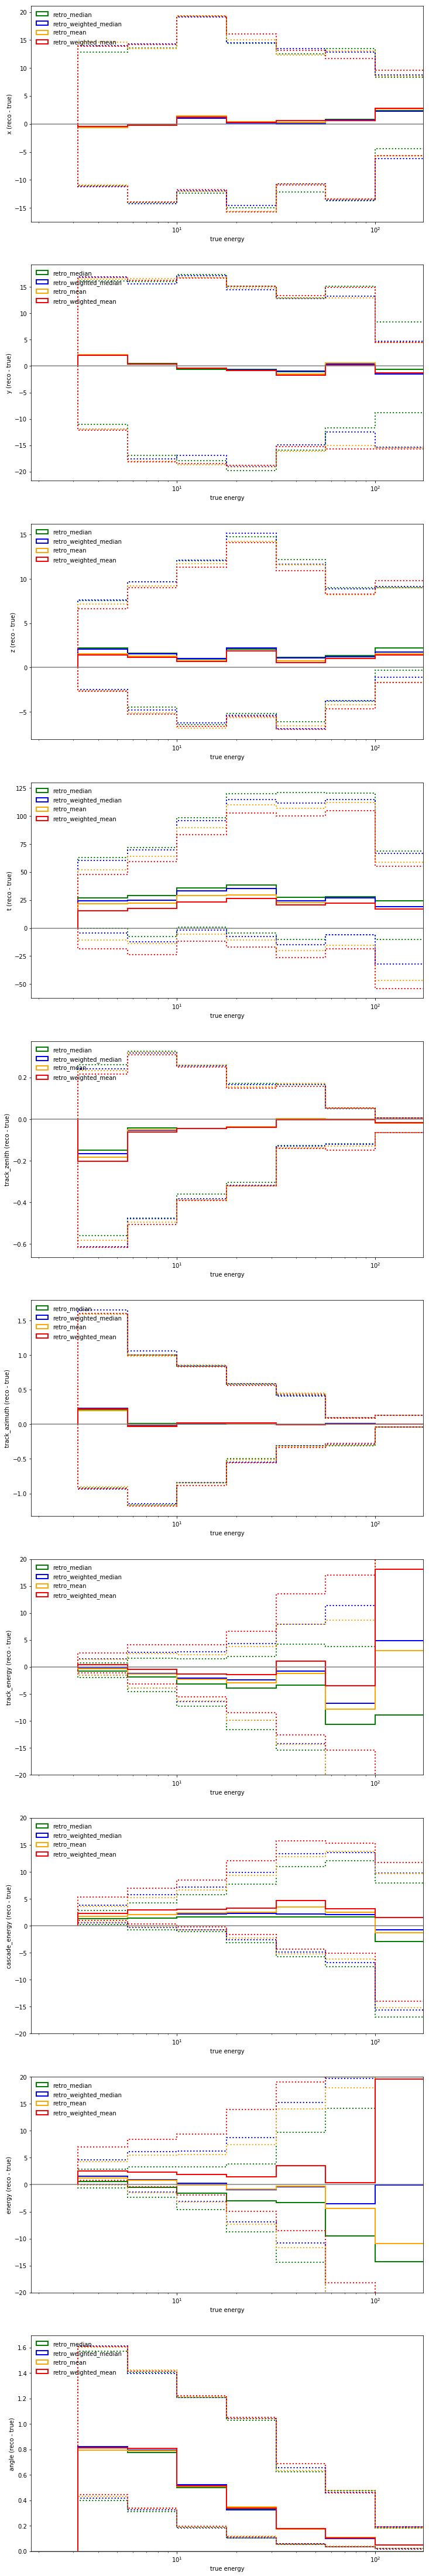

In [164]:
fig, axes = plt.subplots(figsize=(12, 80), ncols=1, nrows=10)
plt.subplots_adjust(hspace = 0.2)


res = []
pegres = []
speres = []

def lower(x):
    if len(x) == 0:
        return 0
    return np.percentile(np.nan_to_num(x), 16)
def upper(x):
    if len(x) == 0:
        return 0
    return np.percentile(np.nan_to_num(x), 84)

for i, dim in enumerate(['x', 'y', 'z', 't', 'track_zenith', 'track_azimuth', 'track_energy', 'cascade_energy', 'energy', 'angle']):
    
    ax1 = axes[i]#,0]
    #ax2 = axes[i,1]
    #ax3 = axes[i,2]
    
    true_energy = np.nan_to_num(data['events']['energy'])


    #for reco, color in zip(['spefit', 'retro', 'pegleg'], ['green', 'blue', 'orange']):
    for reco, color, estimator in zip(['retro', 'retro', 'retro', 'retro'], ['green', 'blue', 'orange', 'red'], ['_median', '_weighted_median', '_mean', '_weighted_mean']):
        if not ('energy' in dim and reco == 'spefit'):    
    
            if dim == 'angle':
                data['events'][reco+'_d_'+dim+estimator] = angular_dist(data['events'][reco+'_track_zenith'+estimator], data['events']['track_zenith'], data['events'][reco+'_track_azimuth'+estimator], data['events']['track_azimuth'])
            else:
                data['events'][reco+'_d_'+dim+estimator] = data['events'][reco+'_'+dim+estimator] - data['events'][dim]

            if 'azimuth' in dim:
                data['events'][reco+'_d_'+dim+estimator]  = (data['events'][reco+'_d_'+dim+estimator] + np.pi)%(2*np.pi) - np.pi

            #ax1.errorbar(true_energy, data['events'][reco+'_d_'+dim], marker='.', c=color, markersize=2, ls='', alpha=0.5)
 
            data.translate(var=reco+'_d_'+dim+estimator, source='events', dest='e_bins',function=np.median)    
            data.translate(var=reco+'_d_'+dim+estimator, source='events', dest='e_bins',function=upper, dest_var=reco+'_d_'+dim+estimator+'_upper')    
            data.translate(var=reco+'_d_'+dim+estimator, source='events', dest='e_bins',function=lower, dest_var=reco+'_d_'+dim+estimator+'_lower')    

            ax1.hist(0.5*(data['e_bins']['energy'][:-1] + data['e_bins']['energy'][1:]), bins=data['e_bins']['energy'], weights=np.nan_to_num(data['e_bins'][reco+'_d_'+dim+estimator]), histtype='step', lw=2, color=color,label=reco+estimator)
            ax1.hist(0.5*(data['e_bins']['energy'][:-1] + data['e_bins']['energy'][1:]), bins=data['e_bins']['energy'], weights=np.nan_to_num(data['e_bins'][reco+'_d_'+dim+estimator+'_upper']), histtype='step', lw=2, color=color, ls=':')
            ax1.hist(0.5*(data['e_bins']['energy'][:-1] + data['e_bins']['energy'][1:]), bins=data['e_bins']['energy'], weights=np.nan_to_num(data['e_bins'][reco+'_d_'+dim+estimator+'_lower']), histtype='step', lw=2, color=color, ls=':')

    
    ax1.set_xlabel('true energy')
    ax1.legend(loc='upper left',ncol=1, frameon=False,numpoints=1,fontsize=10)

    if 'energy' in dim:
        ax1.set_ylim(-20, 20)
    #    ax1.set_ylabel('%s (reco - true)/true'%dim)
    #else:
    ax1.set_ylabel('%s (reco - true)'%dim)
    
    ax1.set_xscale('log')
    
    ax1.set_xlim(true_energy[true_energy != 0].min(), true_energy.max())
    
    #vmax = np.percentile(np.abs(x_reco - x_true),95)
    
    #vmax = np.max(np.abs(np.nan_to_num(data['e_bins']['retro_d_'+dim+'_lower'])))
    #vmax = max(vmax, np.max(np.abs(np.nan_to_num(data['e_bins']['retro_d_'+dim+'_upper']))))
    
    #ax1.set_ylim(-vmax, vmax)
    
    ax1.plot([0.01,1000],[0,0],ls='-', c='gray')
    plt.savefig('estimators.png')